## To get |10> and |01>  equally

{'01': 50, '10': 50}


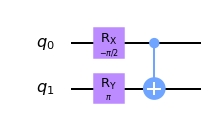

In [1]:
# The ideal circuit would be
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from math import pi
qc = QuantumCircuit(2)
qc.rx(-pi/2, 0)
qc.ry(pi, 1)
qc.cx(0,1)

print(Statevector.from_instruction(qc).sample_counts(100))
qc.draw(output='mpl')

Perform gradient descent on an Rx and Ry gate to get parameters separately. Exclude CNOT for now since entanglement confuses classical expectations.
<br> I checked in the slack channel that it was OK to do things separately like this

In [2]:
#adapted from https://arxiv.org/pdf/1811.04968.pdf

import pennylane as qml
from pennylane import expval
from pennylane.optimize import GradientDescentOptimizer
import random
import math
# Create device

dev = qml.device("forest.qvm", device="2q", noisy=True) #noisy device

# create circuit
@qml.qnode(dev)
def circuit1(var):
    qml.RX(var[0], wires=0)
    qml.RY(var[1], wires=1)
    return expval(qml.PauliY(0)), expval(qml.PauliZ(1))
    #gives the expected value of a Y measurement on the first qubit and a Z measurement on the second



def cost(var):
    #optimiser minimises cost function
    
    y_0, z_1 = circuit1(var)
    return - y_0 + z_1 #optimise for |+> in q0 and |1>  in q1. expval would give 1 and -1 respectively therefore the optimium is -2

# Optimize circuit output
def perform_descent(measurements, verbose=False):
    # Create optimizer
    opt = GradientDescentOptimizer(0.2)
    costs = []
    dev.analytic = False
    dev.shots = measurements #ensures expval returns average of correct number of measurements
    var = [random.random(), random.random()] #randomly choose starting parameters
    for it in range(50):
        opt.update_stepsize(0.5 * math.exp(-it/20)) #my own little adaptive learning rate
        var = opt.step(cost, var)
        c = cost(var)
        if verbose and it % 10 == 0: print("Step {}: cost: {}".format(it, c))
        costs.append(c)
    return var, costs #returns final parameters and cost for every step

Function to build circuit in qiskit using given parameters and return expected results of circuit

In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
def get_results(var):
    qc = QuantumCircuit(2)
    qc.rx(var[0], 0)
    qc.ry(var[1], 1)
    qc.cx(0,1)
    #qc.measure_all()
    return Statevector.from_instruction(qc).sample_counts(100), qc


## Results

Example of results for circuit with 100 measurements per iteration of gradient descent 

Step 0: cost: 0.18
Step 10: cost: -1.6800000000000002
Step 20: cost: -1.88
Step 30: cost: -1.56
Step 40: cost: -1.76
Final circuit parameters: [-1.5557899169599922, 3.154788276564796]
results from a sample of 100 measurements {'01': 50, '10': 50}


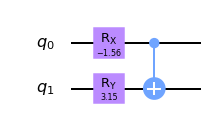

In [4]:
var, c = perform_descent(100, verbose=True)
print("Final circuit parameters:", var)
r, q = get_results(var)
print("results from a sample of 100 measurements", r)
q.draw(output='mpl')

Qsphere visualisation of resulting state

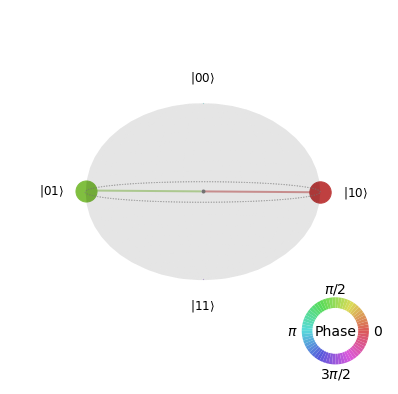

In [5]:
from qiskit.visualization import plot_state_qsphere

state = Statevector.from_instruction(q)
plot_state_qsphere(state)

Produces state with phase pi/2 (for now...)

Get learnt parameters and range of cost values for all numbers of measurements

In [6]:
params = []
costs = []
for m in [1,10,100, 1000]:
    v, c = perform_descent(m)
    params.append(v)
    costs.append(c)
    print(m, "measurements: parameters =", v)
    

1 measurements: parameters = [-1.5779869610695252, 3.1541333135558176]
10 measurements: parameters = [-1.5320431294710355, 3.1392956160096275]
100 measurements: parameters = [-1.5582501803179056, 3.1085941037601703]
1000 measurements: parameters = [-1.5966525894830788, 3.128726906909706]


Plot costs together in one graph

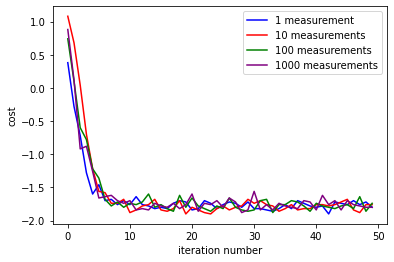

In [7]:
import matplotlib.pyplot as plt
ms = [1,10,100, 1000]
colours = ["b", "r", "g", "purple"]
for i in range(4):
    plt.plot(range(50), costs[i], colours[i], label=str(ms[i]) + " measurement" + 's'*int(ms[i]>1), linewidth=1.5)
plt.xlabel('iteration number')
plt.ylabel('cost')
plt.legend()
plt.show()

In [8]:
for i in range(4):
    r, _ = get_results(params[i])
    print("circuit results with", ms[i], "measurements per iteration:", r) 

circuit results with 1 measurements per iteration: {'01': 51, '10': 49}
circuit results with 10 measurements per iteration: {'01': 49, '10': 51}
circuit results with 100 measurements per iteration: {'01': 56, '10': 44}
circuit results with 1000 measurements per iteration: {'01': 54, '10': 46}


The code succesfully gets equal proportions of |01> and |10> for each number of measurements :)

## Bonus - eliminate phase

{'01': 44, '10': 56}


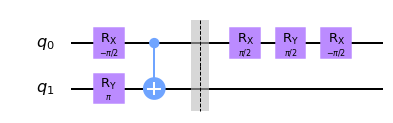

In [16]:
#The ideal correction would be

q = QuantumCircuit(2)
#ideal circuit from before
q.rx(-pi/2, 0)
q.ry(pi, 1)
q.cx(0,1)
q.barrier()

#correction
q.rx(pi/2, 0) #rotates
q.ry(pi/2, 0) #corrects phase
q.rx(-pi/2, 0) #rotates back (ie opposite of previous rotation)

print(Statevector.from_instruction(q).sample_counts(100))
q.draw(output='mpl')

Note: $YX = -iZ$
<br> Therefore, try to perform gradient descent on a modified circuit which corrects q0 to |+>. 

#### Pennylane optimizers
Attempted with various pennylane optimizers to no avail

In [10]:
from pennylane.optimize import AdamOptimizer, AdagradOptimizer

dev2 = qml.device("forest.qvm", device="1q", noisy=True) #doesnt works with noisy device
#dev2 = qml.device("cirq.mixedsimulator", wires=1) #works with non noisy one
prev = 0.0

@qml.qnode(dev2)
def circuit2(var2):
    global prev
    #rotation on q0 from previous circuit
    qml.RX(prev, wires=0)
    
    #correction for optimisation
    qml.RX(var2[0], wires=0)
    qml.RY(var2[1], wires=0)
    qml.RX(-var2[0], wires=0)
    return expval(qml.PauliX(0))

def cost(var2):
    x_0 = circuit2(var2)
    return -x_0 #optimise for 1 (|+>)

#opt2 = GradientDescentOptimizer(0.1)
opt2 = AdamOptimizer(0.1)
#opt2 = AdagradOptimizer()


def descent2(measurements, var0, verbose=False):
    opt2.reset()
    global prev
    prev = var0
    costs = []
    var2 = [random.random(), random.random()] #random starting values
    dev2.analytic = False
    dev2.shots = measurements
    for it in range(1,100):
        var2 = opt2.step(cost, var2)
        if verbose and it % 10 == 0: print("Step {}: cost: {}".format(it, cost(var2)))
        costs.append(cost(var2))
    return var2, costs

In [11]:
ms = [1,10,100,1000]
#ms = [100,1000]
final_params = []
costs = []

for i in range(len(ms)):
    v, c = descent2(ms[i], params[i][0])
    print("with", ms[i], "measurements, final parameters were", v, "with final cost", c[-1])
    final_params.append(v)
    costs.append(c)

with 1 measurements, final parameters were [1.2684514129924687, 1.4523879725360405] with final cost 1.0
with 10 measurements, final parameters were [3.8986749232261015, 5.370462877534312] with final cost 0.8
with 100 measurements, final parameters were [4.767714412053764, -3.610021145424784] with final cost -0.56
with 1000 measurements, final parameters were [-2.255372360333983, -4.864945919624368] with final cost -0.768


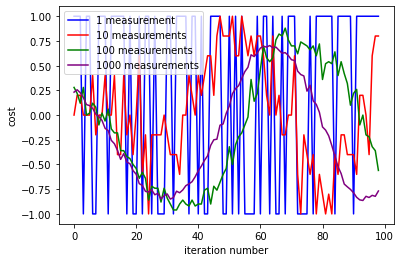

In [12]:
colours = ["b", "r", "g", "purple"]
for i in range(len(ms)):
    plt.plot(range(99), costs[i], colours[i], label=str(ms[i]) + " measurement" + 's'*int(ms[i]>1), linewidth=1.5)
plt.xlabel('iteration number')
plt.ylabel('cost')
plt.legend()
plt.show()

Unable to optimise realiably for any number of measurements

### qiskit SPSA optimiser
Works much better with SPSA optimiser from qiskit library as is designed to work well with noise

In [13]:
from math import pi
from qiskit.aqua.components.optimizers import SPSA

dev2 = qml.device("forest.qvm", device="1q", noisy=True)

prev = 0.0 #temp value

@qml.qnode(dev2)
def circuit2(var2):
    global prev
    #rotation on q0 from previous circuit
    qml.RX(prev, wires=0)
    
    #correction for optimisation
    qml.RX(var2[0], wires=0) #rotates
    qml.RY(var2[1], wires=0) #corrects phase
    qml.RX(-var2[0], wires=0) #rotates back
    return expval(qml.PauliX(0)) #gives expectation for X measurement

def cost(var2):
    x_0 = circuit2(var2)
    return x_0 #optimise for |+>



def spsa_optim(measurements, var0):
    opt = SPSA()
    global prev
    prev = var0 #gets var0 from first section and stores in global variable prev
    var2 = [random.random(), random.random()] #random starting values for parameters
    initial = var2.copy()
    dev2.analytic = False
    dev2.shots = measurements
    grad_func = qml.grad(circuit2, argnum=[0,1]) #gets the pennylane gradient function
    
    #optimises for 2 variables with cost function above and pennylane gradient function
    vals, c, iterations = opt.optimize(2, cost, initial_point=initial, gradient_function=grad_func) 
    return vals, c #returns final parameters and cost 

In [14]:
ms = [1,10,100,1000]
final_params = []
costs = []

for i in range(len(ms)):
    v, c = spsa_optim(ms[i], params[i][0])
    print("with", ms[i], "measurements, final parameters were", v, "with final cost", c)
    final_params.append(v)

with 1 measurements, final parameters were [-1.03893909  4.97161501] with final cost -1.0
with 10 measurements, final parameters were [-1.64744054 -1.46770288] with final cost -0.6
with 100 measurements, final parameters were [1.53384335 1.37291879] with final cost -0.74
with 1000 measurements, final parameters were [1.55690841 1.59855128] with final cost -0.814


## Results of phase correction


Get final circuit results for all 4 measurements

In [15]:
for i in range(4):
    qc = QuantumCircuit(2)

    #original circuit
    qc.rx(params[i][0], 0)
    qc.ry(params[i][1], 1)
    qc.cx(0,1)
    #before correction
    state = Statevector.from_instruction(qc)
    before = plot_state_qsphere(state)
    before.savefig("imgs/qsphere_" + str(i) + "0.png")

    #phase correction
    qc.rx(final_params[i][0], 0)
    qc.ry(final_params[i][1], 0)
    qc.rx(-final_params[i][0], 0)
    
    state = Statevector.from_instruction(qc)
    print("final results for", ms[i], "measurements:", Statevector.from_instruction(qc).sample_counts(1000))
    after = plot_state_qsphere(state)
    after.savefig("imgs/qsphere_" + str(i) + "1.png")

final results for 1 measurements: {'00': 42, '01': 452, '10': 455, '11': 51}
final results for 10 measurements: {'00': 2, '01': 468, '10': 530}
final results for 100 measurements: {'01': 488, '10': 512}
final results for 1000 measurements: {'01': 506, '10': 494}


Compare qsphere before and after correction for all measurements

Measurements | Before | After phase correction
- | - | -
1 | ![](imgs/qsphere_00.png?8) | ![](imgs/qsphere_01.png?8)
10 | ![](imgs/qsphere_10.png?8) | ![](imgs/qsphere_11.png?8)
100 | ![](imgs/qsphere_20.png?8) | ![](imgs/qsphere_21.png?8)
1000 | ![](imgs/qsphere_30.png?8) | ![](imgs/qsphere_31.png?8)


Is able to correct phase of pi/2 or 3pi/2 but does not work for 1 measurement and gives slightly inconsistent results for 10 measurements
<br> Works very well for 100 and 1000 measurements

Thank you! I greatly enjoyed this challenge and learnt a lot in the process